In [43]:
import numpy as np
import torch

np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
y = np.arange(L)

In [46]:
print(y)
print(x)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

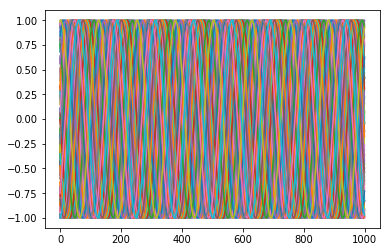

In [47]:
plt.plot(y,data.T)

In [48]:
from __future__ import print_function
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [49]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

STEP:  0
loss: 0.520393948605
loss: 0.519298506528
loss: 0.513111911904
loss: 0.504921517095
loss: 0.493585435681
loss: 0.477124886736
loss: 0.452522505807
loss: 0.416898602638
loss: 0.373161139129
loss: 0.331643071064
loss: 0.295472282187
loss: 0.262562622721
loss: 0.23274598993
loss: 0.204287079495
loss: 0.173893877638
loss: 0.140577498301
loss: 0.108570004562
loss: 0.0838814549863
loss: 0.0673134181501
loss: 0.0562227822518
test loss: 0.0473310943756


IndexError: index 2 is out of bounds for axis 0 with size 2

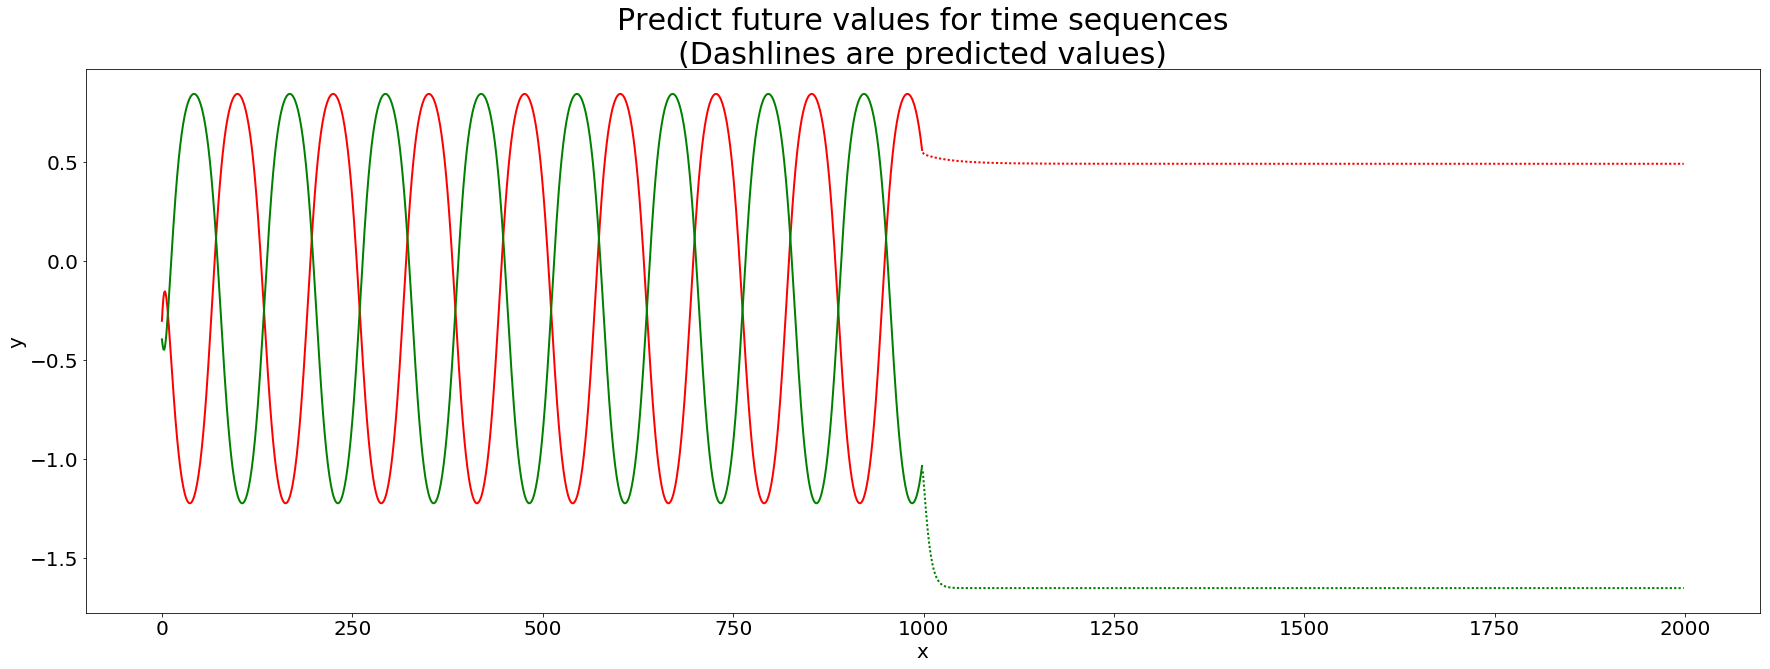

In [52]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')
input = Variable(torch.from_numpy(data[2:,:-1]), requires_grad=False)
target = Variable(torch.from_numpy(data[2:, 1:]), requires_grad=False)
test_input = Variable(torch.from_numpy(data[:2, :-1]), requires_grad=False)
test_target = Variable(torch.from_numpy(data[:2, 1:]), requires_grad=False)
# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.1)
#begin to train
for i in range(50):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict
    future = 1000
    pred = seq(test_input, future = future)
    loss = criterion(pred[:, :-future], test_target)
    print('test loss:', loss.data.numpy()[0])
    y = pred.data.numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.savefig('predicted.pdf'%i)
    plt.close()

In [51]:
data.shape

(100, 1000)